[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jfcrenshaw/pzflow/blob/main/docs/tutorials/intro.ipynb)
[![Open on Github](https://img.shields.io/badge/github-Open%20on%20Github-black?logo=github)](https://github.com/jfcrenshaw/pzflow/blob/main/docs/tutorials/intro.ipynb)


If running in Colab, to switch to GPU, go to the menu and select Runtime -> Change runtime type -> Hardware accelerator -> GPU.

In addition, uncomment and run the following code:

In [1]:
# !pip install pzflow matplotlib

------------------
## Intro to PZFlow

This notebook demonstrates building a normalizing flow with PZFlow to learn the joint probability distribution of some 2-D data.

*You do not need to have any previous knowledge of normalizing flows to get started with PZFlow*.

However if you are interested, here are some good sources:
- Eric Jang's tutorial: [part 1](https://blog.evjang.com/2018/01/nf1.html), [part 2](https://blog.evjang.com/2018/01/nf2.html)
- [Here is a list](https://github.com/janosh/awesome-normalizing-flows) of papers, blogs, videos, and packages
- Two good intro papers using Coupling Layers: [NICE](http://arxiv.org/abs/1605.08803), [Real NVP](http://arxiv.org/abs/1605.08803)
- The paper on [Neural Spline Couplings](https://arxiv.org/abs/1906.04032)

In [1]:
from pzflow import Flow
from pzflow.examples import get_twomoons_data

import jax.numpy as jnp
import matplotlib.pyplot as plt

In [2]:
plt.rcParams["figure.facecolor"] = "white"

First let's load some example data. It's the familiar two moons data set from scikit-learn, loaded in a Pandas DataFrame, which is the data format PZFlow uses on the user-end.

In [3]:
data = get_twomoons_data()
data

,x,y
0,-0.748695,0.777733
1,1.690101,-0.207291
2,2.008558,0.285932
3,1.291547,-0.441167
4,0.808686,-0.481017
...,...,...
99995,1.642738,-0.221286
99996,0.981221,0.327815
99997,0.990856,0.182546
99998,-0.343144,0.877573


Let's plot it to see what it looks like.

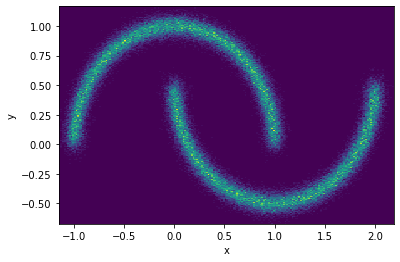

In [4]:
plt.hist2d(data['x'], data['y'], bins=200)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Now let's build a normalizing flow.
The details of constructing a normalizing flow are explored in the following tutorial notebooks, but for now, we can use the default flow built into PZFlow. 
This flow was designed to work well out-of-the-box for most data sets.

The only thing you are required to supply is the name of the columns in your data set.
As you can see in the pandas DataFrame above, our columns are named `"x"` and `"y"`.

In [5]:
flow = Flow(["x", "y"])

Now we can train our normalizing flow.
This is as simple as calling `flow.train(data)`.
There are several training parameters you can set, including the number of epochs, the batch size, the optimizer, and the random seed.
See the `Flow` documentation for more details.
For this example, let's use the defaults, but set `verbose=True` so that training losses are printed throughout the training process.

In [6]:
%%time
losses = flow.train(data, verbose=True)

Training 100 epochs 
Loss:
(0) 2.3212
(1) 0.7040
(6) 0.3620
(11) 0.3410
(16) 0.3193
(21) 0.3124
(26) 0.3140
(31) 0.3226
(36) 0.3028
(41) 0.3105
(46) 0.3054
(51) 0.2984
(56) 0.3031
(61) 0.2963
(66) 0.3060
(71) 0.3016
(76) 0.3027
(81) 0.2962
(86) 0.3023
(91) 0.3067
(96) 0.2991
(100) 0.2978
CPU times: user 4min 58s, sys: 47.8 s, total: 5min 45s
Wall time: 1min 13s


Now let's plot the training losses to make sure everything looks like we expect it to...

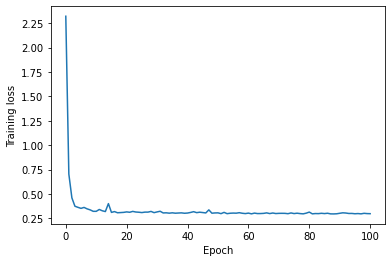

In [7]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.show()

Perfect!

Now we can draw samples from the flow, using the `sample` method.
Let's draw 10000 samples and make another histogram to see if it matches the data.

In [8]:
samples = flow.sample(10_000, seed=0)

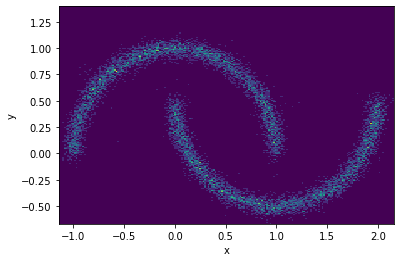

In [10]:
plt.hist2d(samples['x'], samples['y'], bins=200)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Looks great!

We can also use the flow to calculate redshift posteriors using the `posterior` method. We need to provide the name of the column we want to calculate a posterior for, as well as a grid on which to calculate the posterior.

In [11]:
grid = jnp.linspace(-2, 2, 100)
pdfs = flow.posterior(data, column="x", grid=grid)

The result is a big array of posteriors:

In [12]:
pdfs

DeviceArray([[1.1526364e-17, 1.5710681e-17, 2.1710265e-17, ...,
              3.0416501e-04, 4.6119880e-04, 5.1985879e-04],
             [3.9057552e-20, 4.7278035e-20, 5.7521539e-20, ...,
              1.1195179e-02, 5.2259550e-03, 3.2279678e-03],
             [8.9478333e-15, 8.6903539e-15, 8.4864197e-15, ...,
              1.4289128e+00, 2.1520741e+00, 1.8444533e+00],
             ...,
             [1.6390430e-14, 1.6739800e-14, 1.6975609e-14, ...,
              1.9207720e+00, 1.8126062e+00, 1.0248622e+00],
             [9.7047259e-26, 1.2066398e-25, 1.5056109e-25, ...,
              4.8847091e-05, 1.1313723e-04, 1.3389536e-04],
             [8.0042039e-17, 1.2001349e-16, 1.5902662e-16, ...,
              1.3562146e+00, 5.6305081e-01, 6.3225918e-02]],            dtype=float32)

Let's plot the first posterior.

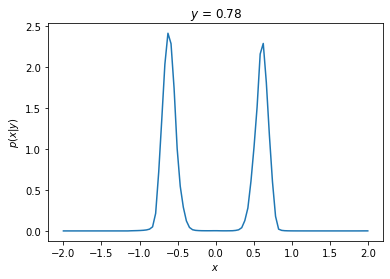

In [13]:
plt.plot(grid, pdfs[0])
plt.title(f"$y$ = {data['y'][0]:.2f}")
plt.xlabel("$x$")
plt.ylabel("$p(x|y)$")
plt.show()

Now let's store some information with the flow about the data it was trained on.

In [14]:
import pzflow
flow.info = f"""
This is an example flow, trained on 100,000 points from the scitkit-learn
two moons data set.

The data set used to train this flow is available in the `examples` module:
>>> from pzflow.examples import two_moons_data
>>> data = get_twomoons_data()

This flow was created with pzflow version {pzflow.__version__}
"""

In [15]:
print(flow.info)


This is an example flow, trained on 100,000 points from the scitkit-learn
two moons data set.

The data set used to train this flow is available in the `examples` module:
>>> from pzflow.examples import two_moons_data
>>> data = get_twomoons_data()

This flow was created with pzflow version 3.0.0



Now let's save the flow to a file that can be loaded later:

In [16]:
flow.save("example_flow.pzflow.pkl")

This file can be loaded on Flow instantiation:

In [17]:
flow = Flow(file="example_flow.pzflow.pkl")